In [154]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import sys
sys.path.insert(0, '../scripts/')

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from causalnex.structure import DAGClassifier
from sklearn.metrics import jaccard_score
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [157]:
root_dir = Path().cwd().parent
data_dir = root_dir / "data"

In [158]:
df = pd.read_csv(data_dir / "data_clean.csv")

In [159]:
df["diagnosis"] = df["diagnosis"].apply(lambda x: 0 if x == "M" else 1)

In [160]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,...,25.380,17.33,184.60,1937.05,0.16220,0.62695,0.7119,0.2654,0.41915,0.11890
1,842517,0,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1937.05,0.12380,0.18660,0.2416,0.1860,0.27500,0.08902
2,84300903,0,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.00,0.14440,0.42450,0.4504,0.2430,0.36130,0.08758
3,84348301,0,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,...,14.910,26.50,98.87,567.70,0.19010,0.62695,0.6869,0.2575,0.41915,0.12301
4,84358402,0,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.00,0.13740,0.20500,0.4000,0.1625,0.23640,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,0,21.56,22.39,142.00,1326.3,0.111000,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,1937.05,0.14100,0.21130,0.4107,0.2216,0.20600,0.07115
565,926682,0,20.13,28.25,131.20,1261.0,0.097800,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.00,0.11660,0.19220,0.3215,0.1628,0.25720,0.06637
566,926954,0,16.60,28.08,108.30,858.1,0.084550,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.00,0.11390,0.30940,0.3403,0.1418,0.22180,0.07820
567,927241,0,20.60,29.33,140.10,1265.0,0.117800,0.22862,0.28241,0.15200,...,25.740,39.42,184.60,1821.00,0.16500,0.62695,0.7855,0.2650,0.40870,0.12301


In [161]:
standard_scaler = StandardScaler()

In [162]:
X = df.iloc[:, 2:]
y = df["diagnosis"]

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [166]:
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

MEAN Score: 0.975
MEAN EFFECT DIRECTIONAL CLASS 0:
compactness_se             0.404760
fractal_dimension_se       0.334037
compactness_mean           0.300730
texture_se                 0.274312
symmetry_se                0.190629
compactness_worst          0.038199
radius_mean                0.037522
texture_mean              -0.000034
symmetry_mean             -0.002285
perimeter_mean            -0.011182
smoothness_mean           -0.028504
area_mean                 -0.034237
smoothness_se             -0.059310
perimeter_se              -0.088082
fractal_dimension_mean    -0.098429
concavity_worst           -0.116531
concave points_worst      -0.172433
smoothness_worst          -0.174506
concavity_se              -0.174822
radius_se                 -0.209381
symmetry_worst            -0.226688
fractal_dimension_worst   -0.243414
concave points_se         -0.269983
perimeter_worst           -0.273686
concave points_mean       -0.361007
area_worst                -0.370589
radius_worst 

(<Figure size 1185.84x902.16 with 1 Axes>, <AxesSubplot:>)

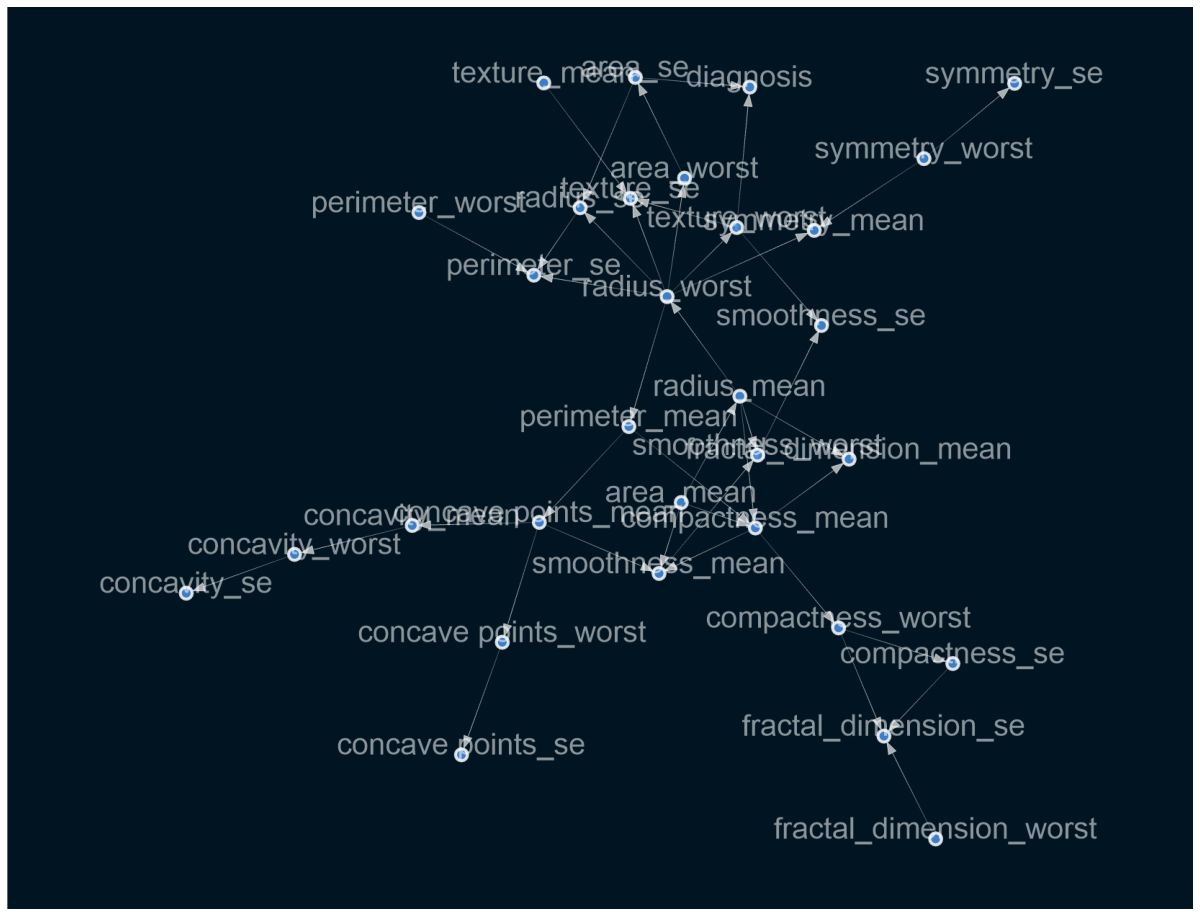

In [94]:
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

clf.fit(X, y)

for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=X.columns.tolist()).sort_values(ascending=False))
    
ground_truth = clf.coef_[i, :]
clf.plot_dag(True)

In [97]:
features = [
    "compactness_se",      
    "fractal_dimension_se",
    "compactness_mean",   
    "texture_se",          
    "symmetry_se",         
    "compactness_worst",          
    "radius_mean",              
]

In [117]:
X_50 = X.sample(frac=0.5)
y_50 = y.iloc[X_50.index.tolist()]

In [178]:
X_train

array([[-1.50747921, -1.42448204, -1.29279808, ...,  2.51730332,
         2.58851646,  2.65782474],
       [-1.08233133, -0.88622227, -0.31858058, ...,  2.64652437,
         2.6989469 ,  2.76500879],
       [-1.46422199, -1.4587844 , -1.40657959, ...,  2.04189892,
         2.2673103 ,  2.40788323],
       ...,
       [-2.33151453, -2.01899777, -1.52964517, ..., -0.04861301,
        -0.01969559,  0.0729114 ],
       [-1.19050309, -0.79570363, -0.78396355, ...,  1.05001236,
         1.319768  ,  1.36733164],
       [-1.25509848, -1.21937085, -1.15324287, ...,  0.33399123,
         0.81031569,  1.2272475 ]])

In [169]:
clf.fit(X_train, y_train)

for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=X_train.columns.tolist()).sort_values(ascending=False))

new_coefs = clf.coef_[i, :]
clf.plot_dag(True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [128]:
# similarity = jaccard_score(ground_truth, new_coefs)

# print(f'Jaccard similarity is equal to: {similarity}')

In [149]:
X_10 = X.sample(frac=0.1)
y_10 = y.iloc[X_10.index.tolist()]
df_5 = df.sample(frac=0.05)

In [150]:
df_5

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
450,9111596,1,11.870,21.54,76.830,432.0,0.06613,0.10640,0.087770,0.023860,...,12.79,28.18,83.510,507.20,0.09457,0.33990,0.32180,0.08750,0.23050,0.09952
430,907914,0,14.900,22.53,102.100,685.0,0.09947,0.22250,0.273300,0.097110,...,16.35,27.57,125.400,832.70,0.14190,0.62695,0.78550,0.24750,0.28660,0.11550
98,862485,1,11.600,12.84,74.340,412.6,0.08983,0.07525,0.041960,0.033500,...,13.06,17.16,82.960,512.50,0.14310,0.18510,0.19220,0.08449,0.27720,0.08756
249,884689,1,11.520,14.93,73.870,406.3,0.10130,0.07808,0.043280,0.029290,...,12.65,21.19,80.880,491.80,0.13890,0.15820,0.18040,0.09608,0.26640,0.07809
154,8711002,1,13.150,15.34,85.310,538.9,0.09384,0.08498,0.092930,0.034830,...,14.77,20.50,97.670,677.30,0.14780,0.22560,0.30090,0.09722,0.38490,0.08633
74,8610175,1,12.310,16.52,79.190,470.9,0.09172,0.06829,0.033720,0.022720,...,14.11,23.21,89.710,611.10,0.11760,0.18430,0.17030,0.08660,0.26180,0.07609
110,864033,1,9.777,16.99,62.500,290.2,0.10370,0.08404,0.043340,0.017780,...,11.05,21.47,71.680,367.00,0.14670,0.17650,0.13000,0.05334,0.25330,0.08468
267,8910499,1,13.590,21.84,87.160,561.0,0.07956,0.08259,0.040720,0.021420,...,14.80,30.04,97.660,661.50,0.10050,0.17300,0.14530,0.06189,0.24460,0.07024
76,8610629,1,13.530,10.94,87.910,559.2,0.12910,0.10470,0.068770,0.065560,...,14.08,12.49,91.360,605.50,0.14510,0.13790,0.08539,0.07407,0.27100,0.07191
89,861598,1,14.640,15.24,95.770,651.9,0.11320,0.13390,0.099660,0.070640,...,16.34,18.24,109.400,803.60,0.12770,0.30890,0.26040,0.13970,0.31510,0.08473


In [153]:
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
import networkx as nx
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE


sm = from_pandas(df_5.iloc[:, 1:], tabu_parent_nodes=["diagnosis"])
plot = plot_structure(sm, graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(plot.draw(format='png'))
# fig = plt.figure(figsize=(20, 10))  # set figsize
# nx.draw_networkx(sm)
# plot.draw("plot.png")

KeyboardInterrupt: 